In [ ]:
import importlib
import pipeline as pp
import stats as st
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

# Fake News Corpus

In [ ]:
importlib.reload(st)

In [ ]:
data_fake_news = pd.read_csv("../1cleaned_file_with_swords.csv", usecols=["content_no_swords_stemmed", "type", "type_binary", "type_binary", "domain"], nrows=1000)#, "sentence_analysis_no_swords"])

In [ ]:
Fake_News_Corpus = st.Fake_News_Corpus(data=data_fake_news, content_label="content_no_swords_stemmed", type_label="type",
                                       binary_type_label='type_binary', domain_label='domain')#, sentence_analysis_label="sentence_analysis_no_swords")

Stat_Fake_News_Corpus = st.Statistics_Fake_News_Corpus(fake_news=Fake_News_Corpus)

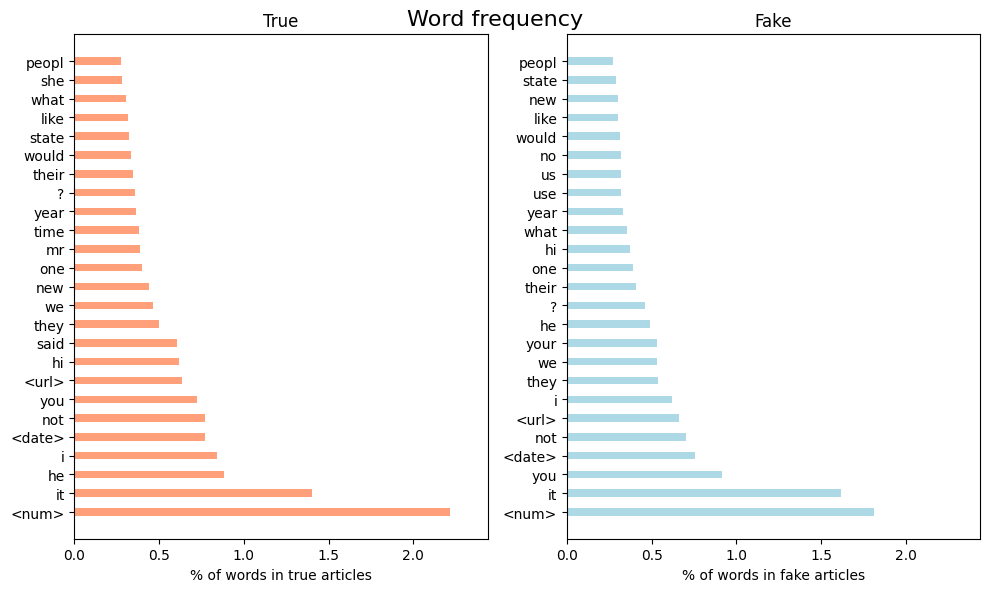

In [198]:
Stat_Fake_News_Corpus.barplot_word_frequency(nwords=25)

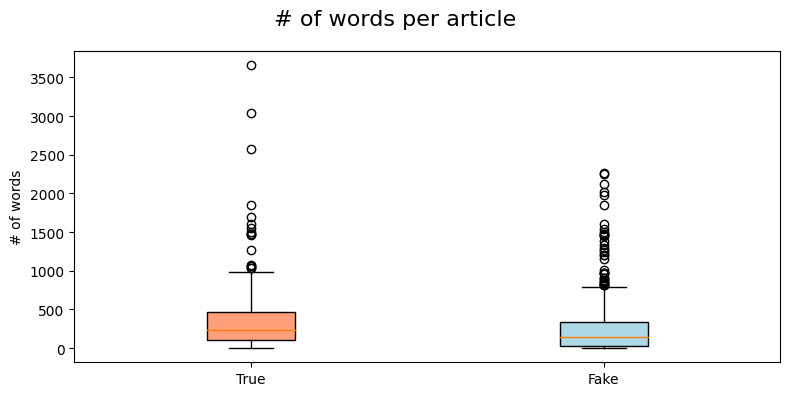

In [199]:
Stat_Fake_News_Corpus.boxplot_word_frequency()

In [200]:
Stat_Fake_News_Corpus.word_frequency()


True:
count     504.000000
mean      324.388889
std       359.435823
min         5.000000
25%       107.000000
50%       232.000000
75%       461.250000
max      3658.000000
Name: content_no_swords_stemmed, dtype: float64

Fake:
count     496.000000
mean      266.963710
std       357.580069
min         0.000000
25%        32.000000
50%       139.500000
75%       337.250000
max      2270.000000
Name: content_no_swords_stemmed, dtype: float64


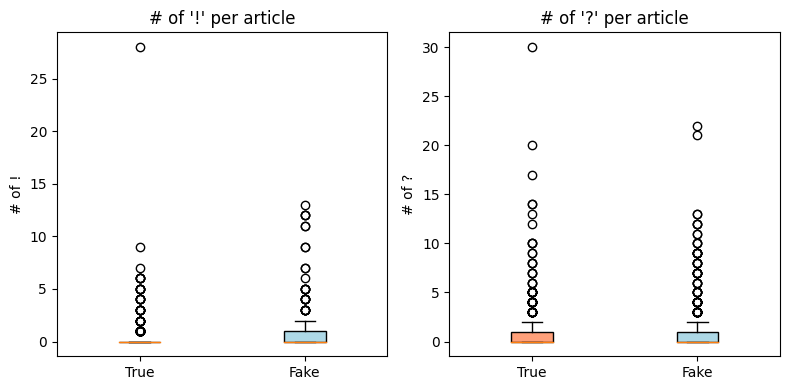

In [201]:
Stat_Fake_News_Corpus.boxplot_char_frequency()

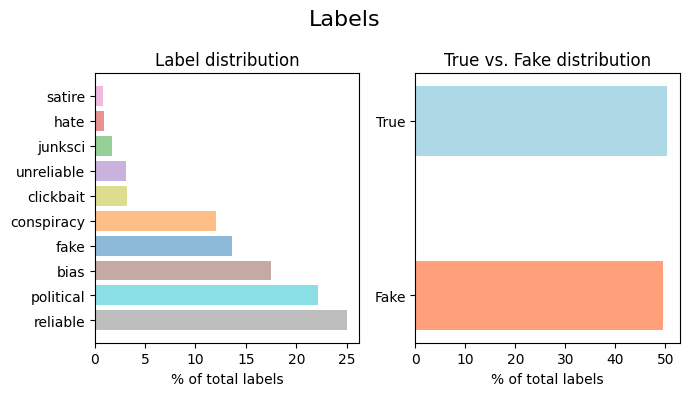

In [202]:
Stat_Fake_News_Corpus.plot_type()

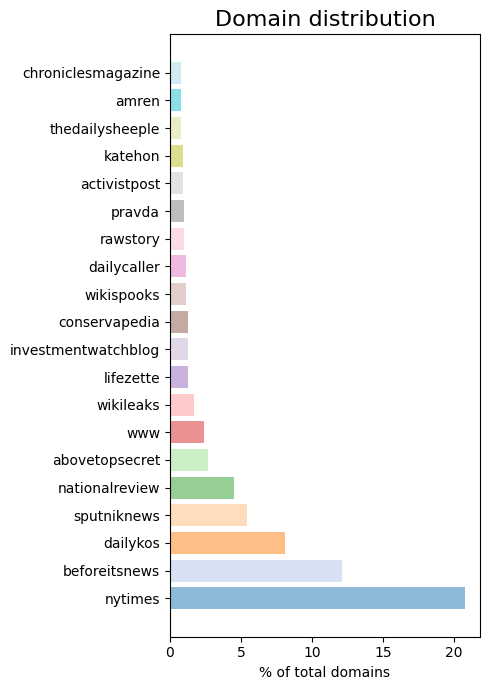

In [203]:
Stat_Fake_News_Corpus.barplot_domain(num=20)

In [204]:
Stat_Fake_News_Corpus.barplot_domain_to_label_contribution(threshold=10, percentage=True)

153
21


KeyboardInterrupt: 

In [ ]:
Stat_Fake_News_Corpus.plot_average_sentence_length()

In [ ]:
Stat_Fake_News_Corpus.plot_pronouns()

In [ ]:
Stat_Fake_News_Corpus.plot_negations()

In [ ]:
Stat_Fake_News_Corpus.plot_sentence_analysis()

# LIAR

In [205]:
importlib.reload(st)

data_liar = pd.read_csv("../datasets/liar_dataset/cleaned/combined_cleaned.csv")

Liar = st.Liar(data=data_liar, type_label="label", binary_type_label='label_binary', statement_label="statement_cleaned", subjects_label='subjects', speaker_label='speaker', party_label='party', sentence_analysis_label="sentence_analysis")

# Fake News Corpus vs. Liar

In [213]:
importlib.reload(st)
Fake_vs_liar = st.Statistics_Fake_News_vs_Liar(fake_news=Fake_News_Corpus, liar=Liar)

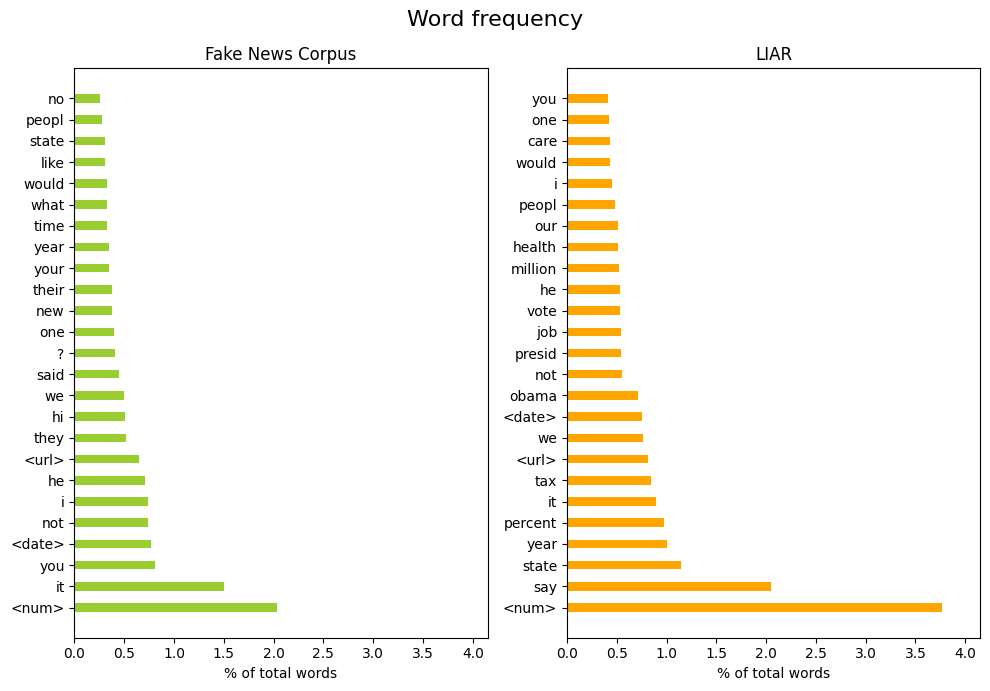

In [214]:
Fake_vs_liar.barplot_word_frequency(nwords=25)

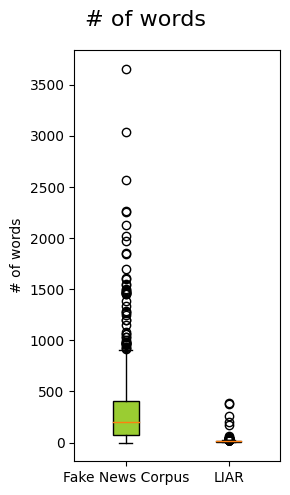

In [215]:
Fake_vs_liar.boxplot_word_frequency()

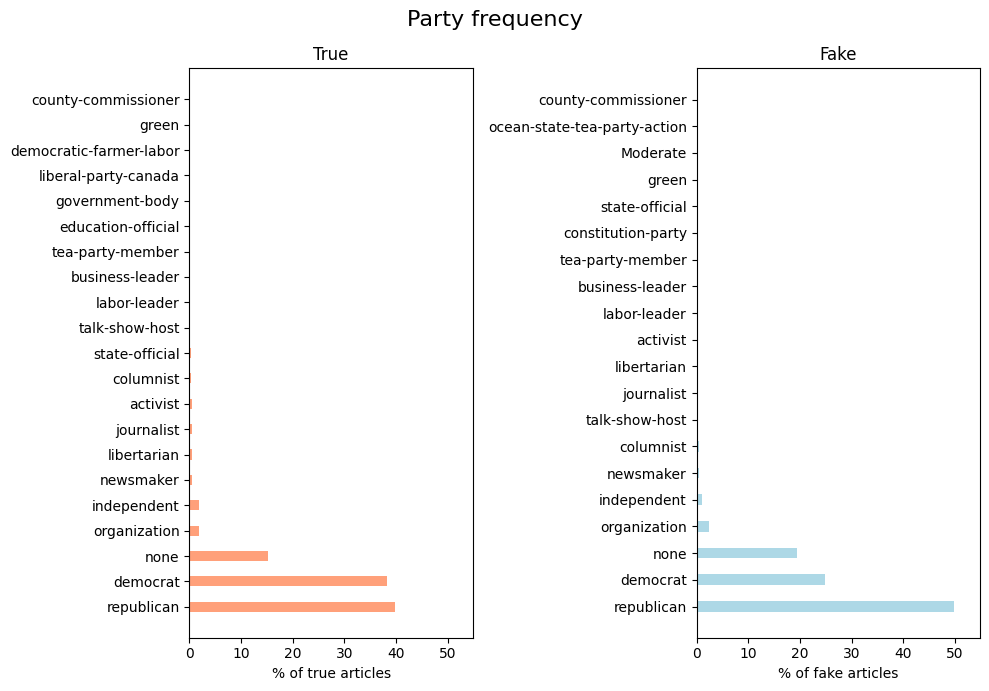

In [216]:
Fake_vs_liar.plot_party(nparties=25)

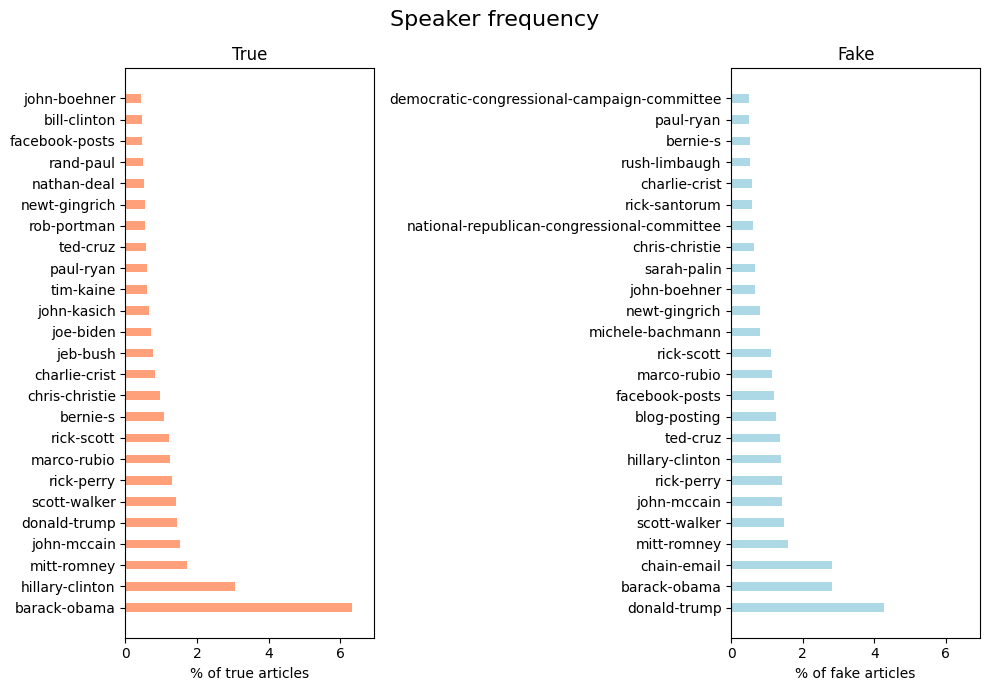

In [217]:
Fake_vs_liar.plot_speaker(nspeakers=25)

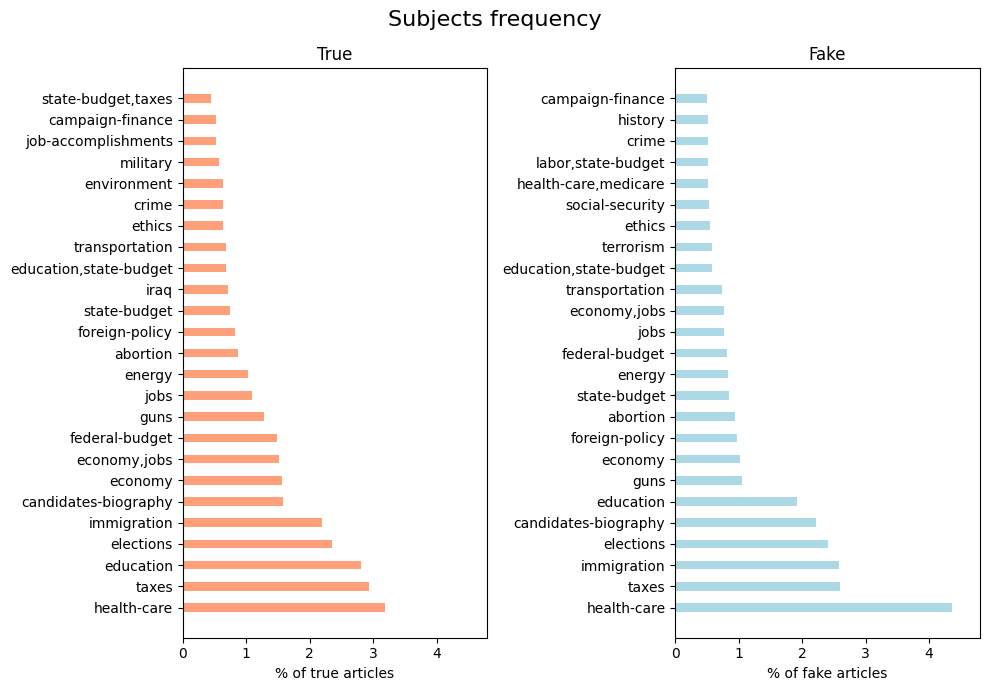

In [218]:
Fake_vs_liar.plot_subjects(nsubjects=25)

# KMeans Clustering

The KMeans clustering algorithm uses the TF-IDF (Term Frequency-Inverse Document Frequency) matrix as input to cluster the documents into k clusters. The TF-IDF matrix represents each document as a vector of term frequencies, normalized by their inverse document frequency across the corpus.

The KMeans algorithm then iteratively assigns each document to a cluster and updates the cluster centroids until convergence. The assignment is based on the similarity between the document vector and the centroid of each cluster. The similarity metric used is the Euclidean distance between the document vector and the centroid vector in the TF-IDF space.

In addition to the TF-IDF matrix, the KMeans algorithm takes several parameters, including the number of clusters (k), the initialization method (e.g., k-means++), the maximum number of iterations, and the number of times the algorithm will be run with different random initializations.

In [219]:
# Vectorize the corpus using TF-IDF
# Convert non-string values to string
content_cleaned_str = data['content_cleaned'].apply(lambda x: str(x))
# Vectorize the corpus using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(content_cleaned_str)

NameError: name 'data' is not defined

### Plot the elbow curve to determine the optimal number of clusters.

In [ ]:
# Calculate SSE for different values of k
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(tfidf)
    sse[k] = kmeans.inertia_ 

# Plot SSE against k
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Perform clustering using the result from the elbow curve.

In [ ]:
# Perform K-Means clustering
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=10)
kmeans.fit(tfidf)

# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

In [ ]:
# Calculate silhouette score
silhouette_avg = silhouette_score(tfidf.toarray(), kmeans.labels_, metric='euclidean', n_jobs=-1)

# Print silhouette score
print("The average silhouette_score is :", silhouette_avg)

### Plot the clusters using a a scatterplot in 2d with PCA.

In [ ]:
# Reduce the dimensions of the data using PCA
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf.toarray())

label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}
colors = [label_to_color[label] for label in kmeans.labels_]

# Visualize the clusters
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], 
            c=colors, 
            cmap='rainbow',
            )
plt.show()

In [ ]:
kmeans.labels_

In [ ]:
label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}

In [ ]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

In [ ]:
# add the list with the cluster labels to the dataframe
# modify the cluster label to be a string with the color of the cluster plus the word cluster in front
data['cluster'] = kmeans.labels_
# add the cluster label to the content

# concat the cluster label to the content

# create a new column 'cluster_color' that maps cluster labels to color codes
data['cluster_color'] = data['cluster'].map(label_to_color)

# create a new column 'cluster_string' that concatenates the color code and cluster label string
data['cluster_string'] = data['cluster_color'] + 'Cluster'

data['content_with_cluster'] = data['content'] + ' ' + data['cluster_string'].astype(str)

data['content'] = data['content'].apply(lambda x: x + " " + str(kmeans.labels_))

In [ ]:

cluster_top_terms = {}

for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
        # build a dict with the top 10 terms for each cluster
        cluster_top_terms[i] = [terms[j] for j in order_centroids[i, :10]]
    print()

for cluster_label in cluster_top_terms.keys():
    # get the rows corresponding to the current cluster label
    cluster_rows = data[data['cluster'] == cluster_label]
    
    # join the top terms for the current cluster as a string
    top_terms_str = ' '.join(cluster_top_terms[cluster_label])
    
    # add the top terms to the content_with_cluster column for the current cluster rows
    data.loc[cluster_rows.index, 'content_with_cluster'] += ' ' + top_terms_str

# data.to_csv('../datasets/big/dataset_unbalanced_cleaned_cluster.csv', index=False)
data.iloc[0]['content_with_cluster']


In [ ]:
kmeans.labels_
data.iloc[0]['content_with_cluster']

In [ ]:
# Print the number of documents in each cluster
for i in range(num_clusters):
    print(f"Number of documents in cluster {i}, {label_to_color[i]}: {len(np.arange(0, tfidf.shape[0])[kmeans.labels_ == i])}")

In [ ]:
# Print a sample of documents in each cluster
print("Sample documents in each cluster:")
for i in range(num_clusters):
    print(f"********************************************************************")
    print(f"Cluster {i} documents: ")
    cluster = np.arange(0, tfidf.shape[0])[kmeans.labels_ == i]
    sample_docs = np.random.choice(cluster, 5, replace=False)
    for doc_index in sample_docs:
        print(f"\nTitle: {data['title'].iloc[doc_index]}")
        print(f"Content: {data['content'].iloc[doc_index]}")
        print("-"*50)


## Outliers

In [ ]:
# Compute the distance between each point and its centroid
distances = np.sqrt(((tfidf.toarray() - kmeans.cluster_centers_[kmeans.labels_])**2).sum(axis=1))

In [ ]:
data['distance'] = distances

for i in range(kmeans.n_clusters):
    cluster_df = data[data['cluster'] == i]
    outliers = cluster_df.nlargest(5, 'distance')
    print(f"Top 10 outliers in cluster {i}:")
    # if i ==2 :
    print(outliers['distance'])

In [ ]:
# Identify the outliers as points that are farthest away from their centroid
outliers = np.argsort(distances)[::-1][:30]  # top 10 outliers
print('Outliers:', outliers)

In [ ]:
for idx in outliers:
    print(f"\nOutlier {idx}:")
    print(f"Domain: {data['domain'][idx]}")
    print(f"Title: {data['title'][idx]}")
    print(f"Content: {data['content'][idx]}")

In [ ]:
# add the cluster labels as a new column to the dataframe
data['cluster'] = kmeans.labels_

# create a list of dataframes, one for each cluster
cluster_dfs = [data[data['cluster'] == i] for i in range(kmeans.n_clusters)]

In [ ]:
# print the number of data points in each cluster dataframe
for i, cluster_df in enumerate(cluster_dfs):
    print(f"Number of data points in cluster {i}, {label_to_color[i]}: {len(cluster_df)}")
    # write to csv
    cluster_df.to_csv(f"tmp/cluster_{i}.csv", index=False)

## Stacked bar plot for each cluster

In [ ]:
# Create contingency table of true/false values for binary column in each cluster
df = pd.DataFrame({'cluster': kmeans.labels_, 'binary_column': data['type']})
contingency_table = pd.crosstab(df['cluster'], df['binary_column'], normalize='index')

# Plot stacked bar chart
contingency_table.plot(kind='bar', stacked=True)
plt.title('Proportion of True/False Values for Binary Column in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

In [ ]:
# Calculate distances from each data point to its nearest centroid
distances = np.min(cdist(tfidf.toarray(), kmeans.cluster_centers_, 'euclidean'), axis=1)

# Calculate the interquartile range and the upper and lower bounds for outlier detection
q1, q3 = np.percentile(distances, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 10.5 * iqr
upper_bound = q3 + 10.5 * iqr

# Identify the outliers
outliers = np.where((distances < lower_bound) | (distances > upper_bound))[0]

# Print the number of outliers and their indices
print(f"Number of outliers: {len(outliers)}")
print("Outlier indices: ", outliers)

# Print the content of the outlier articles
for idx in outliers:
    print(f"\nOutlier {idx}:\n{data['content'][idx]}")
